Deep Ritz Method

In [179]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.special import k0
import time

In [180]:
device = torch.device('cuda:3')

### Neural Network

In [186]:
# Build a neural network

class model(nn.Module) :
    def __init__(self, hidden_dims) :                    # Hidden_dims : [h1, h2, h3, ..., hn]
        super(model, self).__init__()
        
        self.layers = [nn.Linear(hidden_dims[0], hidden_dims[1])]
        for i in range(1,len(hidden_dims)-2) :
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
        self.layers.append(nn.Linear(hidden_dims[i+1], hidden_dims[-1]))
        self.layers = nn.ModuleList(self.layers)
        
        for layer in self.layers :                       # Weight initialization
            nn.init.xavier_uniform_(layer.weight)        # Also known as Glorot initialization
        
        self.act = nn.GELU()
    
    def forward(self, x) :
        x = self.act(self.layers[0](x))
        for layer in self.layers[1:-1] :
            y = self.act(layer(x))
            x = self.act(layer(y)) + x
        x = self.layers[-1](x)
        return x

### Compute $\frac{dy}{dt}$

In [85]:
def derivative(y, t) : 
    return torch.autograd.grad(y, t, create_graph=True,\
                               grad_outputs=torch.ones(y.size()).to(device))[0]

# 1. 2D Square boundary

### Dataset generation

In [187]:
Nx = 50                                                   # Number of samples
Ny = 50                                                   # Number of samples
x = torch.linspace(0, 1, Nx)                             # Input data for x (N x 1)
y = torch.linspace(0, 1, Ny)                             # Input data for y (N x 1)

xy = torch.meshgrid(x,y)
xy_grid = torch.cat([xy[0].reshape(-1,1), xy[1].reshape(-1,1)],dim=1)

x_bdry = xy_grid[torch.logical_or((xy_grid[:,0]==1), (xy_grid[:,0]==0))]
y_bdry = xy_grid[torch.logical_or((xy_grid[:,1]==1), (xy_grid[:,1]==0))]
xy_bdry = torch.cat([x_bdry, y_bdry])
u_bdry = (xy_bdry[:,0]*xy_bdry[:,1]).view(-1,1)

In [188]:
x_2 = torch.tensor(0.3)
y_2 = torch.tensor(0.7)
k = 1.0

def green_no_boundary(x, y, x_2, y_2):
    if k == 0:
        return -0.5/torch.pi*torch.log(torch.sqrt((x - x_2)**2 + (y - y_2)**2))
    else:
        return (0.5/torch.pi*k0(k*torch.sqrt((x - x_2)**2 + (y - y_2)**2))).clone().detach()

u_bdry = green_no_boundary(xy_bdry[:,0], xy_bdry[:,1], x_2, y_2).view(-1,1)

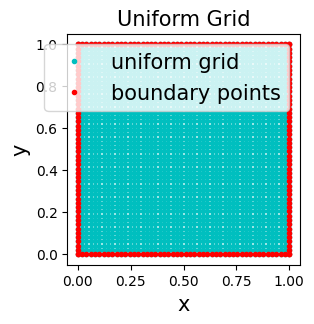

In [189]:
plt.figure(figsize=(3,3))
plt.plot(xy_grid[:,0], xy_grid[:,1], 'co', markersize=3, label='uniform grid')
plt.plot(xy_bdry[:,0], xy_bdry[:,1], 'ro', markersize=3, label='boundary points')
plt.legend(loc='upper right', fontsize=15)
plt.title('Uniform Grid', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.savefig('drm_data')

# Training

In [190]:
# Prepare for training

network = model(hidden_dims=[2,10,10,10,1]).to(device)       # Pass the network to GPU
xy_grid = xy_grid.to(device).requires_grad_(True)            # Pass data to GPU
xy_bdry = xy_bdry.to(device)                                 # Pass data to GPU
u_bdry = u_bdry.to(device)
x, y = x.to(device), y.to(device)
loss_f = nn.MSELoss()                                  # Mean Square Error loss function
optimizer = optim.Adam(network.parameters(), lr=1e-3)  # Adam optimizer
EPOCHS = 20000                                         # Number of Training Iterations

In [191]:
# Train
beta = 500
loss_list = []
network.train()
x_2 = torch.tensor(0.3)
y_2 = torch.tensor(0.7)
mollifier = lambda x: normalized_bump(x, a=0.1)

for i in range(1, EPOCHS+1) :
    optimizer.zero_grad()
    output = network(xy_grid)
    output_bdry = network(xy_bdry)
    grad_output = derivative(output, xy_grid)
    
    integrand = 0.5*torch.pow(torch.norm(grad_output, dim=1), 2).view(-1,1) \
              + (0.5*(k*output)**2).view(-1,1)
    integrand_bdry = (output_bdry-u_bdry)**2
    
    loss_ge = integrand.mean()#torch.trapz(torch.trapz(integrand.view(Nx,Ny), x), y) 
    loss_bdry = integrand_bdry.sum() * (1/Nx)
    
    loss = loss_ge + beta * loss_bdry
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if not i % 100 or True:
        print('EPOCH : %6d/%6d | Loss_ge : %8.7f | Loss_bdry : %8.7f' %(i, EPOCHS, loss_ge.item(), loss_bdry.item()))
        clear_output(wait=True)
print('Training Finished.')

Training Finished.


In [192]:
torch.save(network, 'DRM_d=2.pt')
network = torch.load('DRM_d=2.pt', map_location=device)
pred = network(xy_grid)

## True Green's function

In [193]:
def eigenvalue(nx, ny):
    return (nx**2 + ny**2)*torch.pi**2 + k**2

def eigenfunction(x, y, nx, ny):
    return 2*torch.sin(nx*torch.pi*x.clone().detach())*torch.sin(ny*torch.pi*y.clone().detach())

def true_green(x, y, x_2, y_2):
    N_cutoff = 100
    value = 0
    for n_x in range(1, N_cutoff):
        for n_y in range(1, N_cutoff):
            value = value + eigenfunction(x, y, n_x, n_y)*eigenfunction(x_2, y_2, n_x, n_y)/eigenvalue(n_x, n_y)

    return value.clone().detach()

true = true_green(xy_grid[:,0].cpu().detach(), xy_grid[:,1].cpu().detach(), x_2, y_2).view(-1,1)

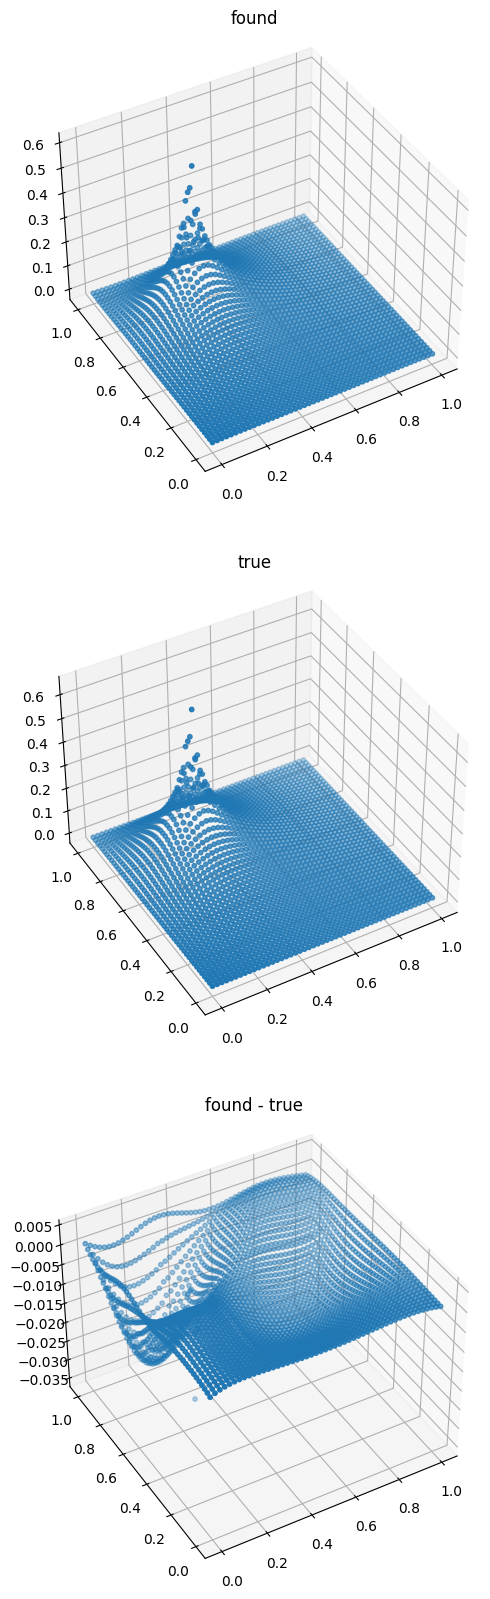

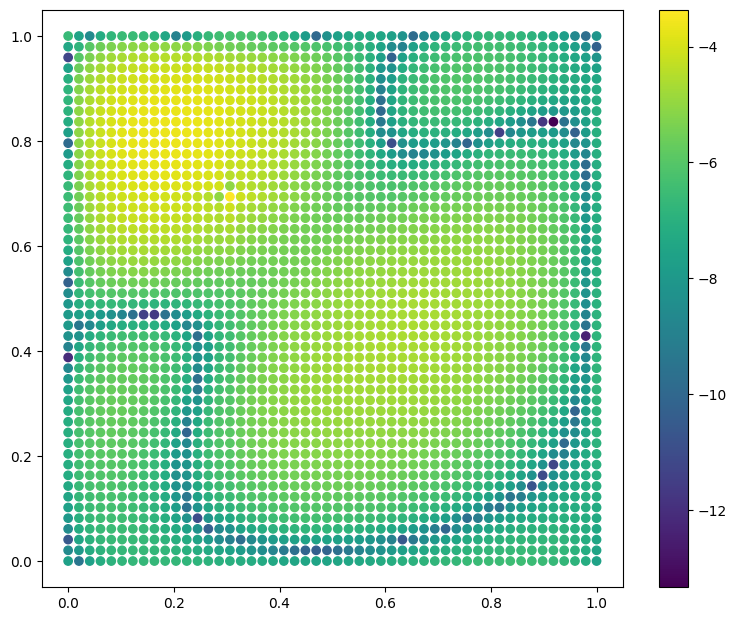

In [194]:
sizeparam = 20
fig = plt.figure(figsize=(sizeparam*3,sizeparam))
zz = pred.cpu().detach()
g0 = green_no_boundary(xy_grid[:,0].cpu().detach(), xy_grid[:,1].cpu().detach(), x_2, y_2).view(-1,1)
ax = fig.add_subplot(311, projection='3d')
ax.view_init(elev=40., azim=-120)
ax.set_title("found")
ax.scatter(xy_grid[:,0].cpu().detach(), xy_grid[:,1].cpu().detach(), g0 - zz, s=10)

ax = fig.add_subplot(312, projection='3d')
ax.view_init(elev=40., azim=-120)
ax.set_title("true")
ax.scatter(xy_grid[:,0].cpu().detach(), xy_grid[:,1].cpu().detach(), true, s=10)

ax = fig.add_subplot(313, projection='3d')
ax.view_init(elev=40., azim=-120)
ax.set_title("found - true")
ax.scatter(xy_grid[:,0].cpu().detach(), xy_grid[:,1].cpu().detach(), (g0 - zz - true), s=10)



sizeparam = 3*Nx/20
plt.figure(figsize=(1.25*sizeparam,sizeparam))

plt.scatter(xy_grid[:,0].cpu().detach(), xy_grid[:,1].cpu().detach(), c = torch.log(torch.abs((g0 - zz - true))))
plt.colorbar()
plt.show()

# 2. 2D Circular boundary

In [219]:
grid_size = 50  # 그리드의 크기
x_2 = torch.tensor(0.3)
y_2 = torch.tensor(0.0)
r_2 = torch.tensor(0.3)
theta_2 = torch.tensor(0.0)
k = 0.005

Nx = grid_size                                                   # Number of samples
Ny = grid_size                                                   # Number of samples
x = torch.linspace(-1, 1, Nx)                             # Input data for x (N x 1)
y = torch.linspace(-1, 1, Ny)                             # Input data for y (N x 1)
xy = torch.meshgrid(x,y)
xy_cartesian = torch.cat([xy[0].reshape(-1,1), xy[1].reshape(-1,1)],dim=1)
xy_polar = xy_cartesian[torch.le(torch.sqrt(xy_cartesian[:,0]**2 + xy_cartesian[:,1]**2), 1)]
xy_grid = xy_polar
eps = 1./grid_size #loss function에서 soft하게 컨디션 적용?
xy_bdry = xy_cartesian[torch.lt(torch.abs(torch.sqrt(xy_cartesian[:,0]**2 + xy_cartesian[:,1]**2) - 1.0) , eps)]
u_bdry = green_no_boundary(xy_bdry[:,0], xy_bdry[:,1], x_2, y_2).view(-1,1)

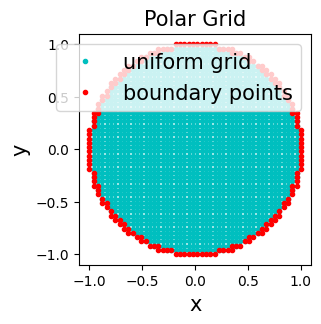

In [220]:
plt.figure(figsize=(3,3))
plt.plot(xy_grid[:,0], xy_grid[:,1], 'co', markersize=3, label='uniform grid')
plt.plot(xy_bdry[:,0], xy_bdry[:,1], 'ro', markersize=3, label='boundary points')
plt.legend(loc='upper right', fontsize=15)
plt.title('Polar Grid', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.savefig('drm_data')

# True Green's function

In [209]:
from scipy.special import jn, jn_zeros

def true_green_disk(r, theta, r_2, theta_2):
    N_cutoff = 100
    M_cutoff = 500
    def create_zeros_n(n):
        return jn_zeros(n,M_cutoff)

    def eigenfunction_disk(r, theta, n, m, zero):
        coefficient = 2. / jn(n + 1, zero)**2
        return (coefficient * jn(n, zero*r) * torch.exp(1j * n * theta)).clone().detach()
        
    value = 0
    for n in range(-N_cutoff, N_cutoff + 1):
        z_nm = create_zeros_n(abs(n))
        for m in range(1, M_cutoff):
            zero = z_nm[m - 1]
            eigenvalue_disk = zero**2 + k**2
            value = value + torch.conj(eigenfunction_disk(r, theta, n, m, zero))*eigenfunction_disk(r_2, theta_2, n, m, zero)/eigenvalue_disk

    return value.clone().detach()

In [210]:
xy_detach = xy_grid.cpu().detach()
xx = xy_detach[:,0]
yy = xy_detach[:,1]

r = torch.sqrt(xx**2 + yy**2)
theta = torch.atan2(yy, xx)

start = time.time()
true_green = true_green_disk(r, theta, r_2, theta_2)
print(f"{time.time()-start:.4f} sec")

884.9692 sec


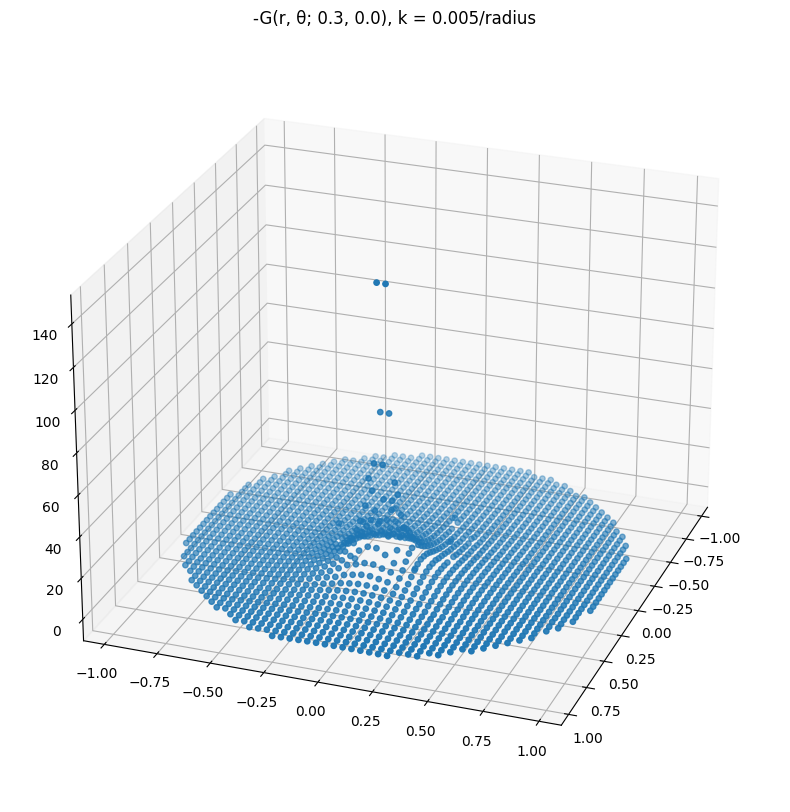

In [211]:
sizeparam = 10
fig = plt.figure(figsize=(sizeparam*3,sizeparam))

ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=25., azim=20)
ax.scatter(xx, yy, true_green, s=15)
plt.title("-G(r, θ; 0.3, 0.0), k = 0.005/radius")
plt.show()

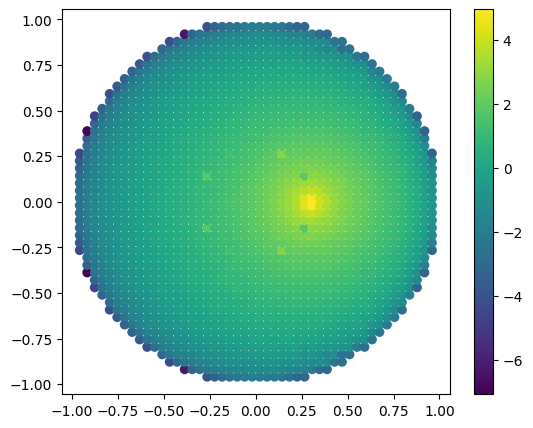

In [212]:
sizeparam = 5
plt.figure(figsize=(1.25*sizeparam,sizeparam))

plt.scatter(xx, yy, c= torch.log(true_green))
plt.colorbar()
plt.show()

# Training

In [213]:
# Prepare for training

network = model(hidden_dims=[2,10,10,10,1]).to(device)       # Pass the network to GPU
xy_grid = xy_grid.to(device).requires_grad_(True)            # Pass data to GPU
xy_bdry = xy_bdry.to(device)                                 # Pass data to GPU
u_bdry = u_bdry.to(device)
x, y = x.to(device), y.to(device)
loss_f = nn.MSELoss()                                  # Mean Square Error loss function
optimizer = optim.Adam(network.parameters(), lr=1e-3)  # Adam optimizer
EPOCHS = 20000                                         # Number of Training Iterations

In [214]:
# Train
beta = 500
loss_list = []
network.train()

for i in range(1, EPOCHS+1) :
    optimizer.zero_grad()
    output = network(xy_grid)
    output_bdry = network(xy_bdry)
    grad_output = derivative(output, xy_grid)
    
    integrand = 0.5*torch.pow(torch.norm(grad_output, dim=1), 2).view(-1,1) \
              + (0.5*(k*output)**2).view(-1,1)
    integrand_bdry = (output_bdry-u_bdry)**2
    
    loss_ge = integrand.mean()#torch.trapz(torch.trapz(integrand.view(Nx,Ny), x), y) 
    loss_bdry = integrand_bdry.sum() * (1/Nx)
    
    loss = loss_ge + beta * loss_bdry
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if not i % 100 or True:
        print('EPOCH : %6d/%6d | Loss_ge : %8.7f | Loss_bdry : %8.7f' %(i, EPOCHS, loss_ge.item(), loss_bdry.item()))
        clear_output(wait=True)
print('Training Finished.')

Training Finished.


In [215]:
torch.save(network, 'DRM_d=2.pt')
network = torch.load('DRM_d=2.pt', map_location=device)
pred = network(xy_grid)

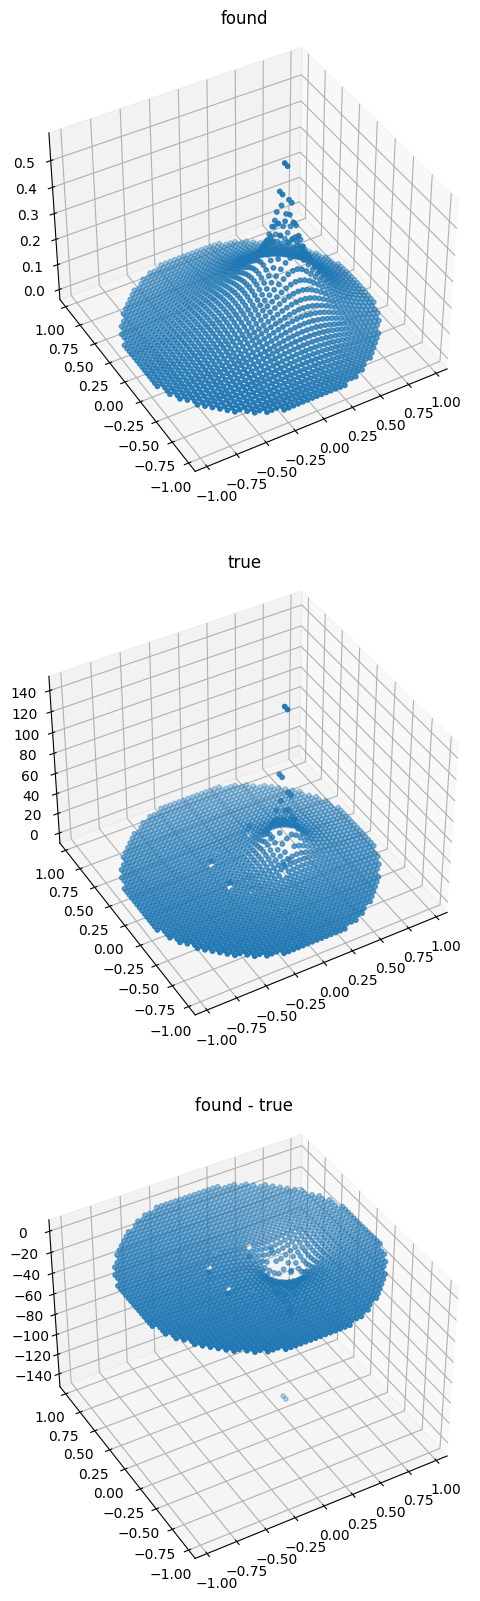

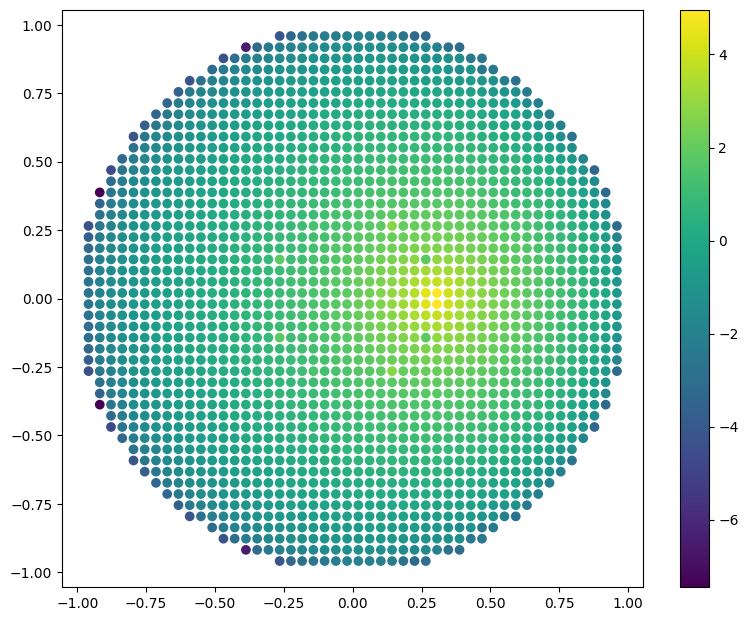

In [216]:
sizeparam = 20
fig = plt.figure(figsize=(sizeparam*3,sizeparam))


zz = pred.cpu().detach()
g0 = green_no_boundary(xy_grid[:,0].cpu().detach(), xy_grid[:,1].cpu().detach(), x_2, y_2).view(-1,1)

ax = fig.add_subplot(311, projection='3d')
ax.view_init(elev=40., azim=-120)
ax.set_title("found")
ax.scatter(xy_grid[:,0].cpu().detach(), xy_grid[:,1].cpu().detach(), g0 - zz, s=10)


ax = fig.add_subplot(312, projection='3d')
ax.view_init(elev=40., azim=-120)
ax.set_title("true")
ax.scatter(xy_grid[:,0].cpu().detach(), xy_grid[:,1].cpu().detach(), true_green, s=10)

ax = fig.add_subplot(313, projection='3d')
ax.view_init(elev=40., azim=-120)
ax.set_title("found - true")
ax.scatter(xy_grid[:,0].cpu().detach(), xy_grid[:,1].cpu().detach(), ((g0 - zz)[0] - true_green), s=10)

sizeparam = 3*Nx/20
plt.figure(figsize=(1.25*sizeparam,sizeparam))

plt.scatter(xy_grid[:,0].cpu().detach(), xy_grid[:,1].cpu().detach(), c = torch.log(torch.abs((g0 - zz)[0] - true_green)))
plt.colorbar()
plt.show()

# 3. Equilateral Triangle

In [221]:
grid_size = 50  # 그리드의 크기
x_2 = torch.tensor(0.5)
y_2 = 0.5/sqrt3
x_2, y_2 = 0.3, 0.2
k = 10.0

Nx = grid_size                                                   # Number of samples
Ny = grid_size                                                   # Number of samples
x = torch.linspace(0, 1, Nx)                             # Input data for x (N x 1)
y = torch.linspace(0, 1, Ny)                             # Input data for y (N x 1)
xy = torch.meshgrid(x,y)
xy_cartesian = torch.cat([xy[0].reshape(-1,1), xy[1].reshape(-1,1)],dim=1)
sqrt3 = torch.sqrt(torch.tensor(3.0))
xy_polar = xy_cartesian[torch.logical_and(torch.logical_and(xy_cartesian[:,0] >= 0, xy_cartesian[:,1] <= xy_cartesian[:,0]*sqrt3), xy_cartesian[:,1] <= (1 - xy_cartesian[:,0])*sqrt3)]
xy_grid = xy_polar
eps = 1./grid_size #loss function에서 soft하게 컨디션 적용?
logic = torch.logical_or(xy_cartesian[:,1] == 0, torch.abs(xy_cartesian[:,1] - xy_cartesian[:,0]*sqrt3) < eps)
logic = torch.logical_or(logic, torch.abs(xy_cartesian[:,1] - (1 - xy_cartesian[:,0])*sqrt3) < eps)
logic = torch.logical_and(logic, xy_cartesian[:,1] <= 0.5*sqrt3)
xy_bdry = xy_cartesian[logic]
#xy_bdry = xy_cartesian[torch.abs(torch.sqrt(xy_cartesian[:,0]**2 + xy_cartesian[:,1]**2) - 1.0) < eps]

In [222]:
u_bdry = green_no_boundary(xy_bdry[:,0], xy_bdry[:,1], x_2, y_2).view(-1,1)

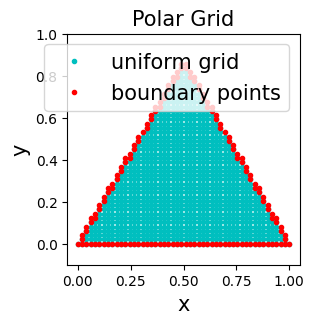

In [223]:
plt.figure(figsize=(3,3))
plt.plot(xy_grid[:,0], xy_grid[:,1], 'co', markersize=3, label='uniform grid')
plt.plot(xy_bdry[:,0], xy_bdry[:,1], 'ro', markersize=3, label='boundary points')
plt.legend(loc='upper right', fontsize=15)
plt.title('Polar Grid', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.ylim([-0.1,1.0])
plt.savefig('drm_data')

### True Green's function

In [240]:
import matplotlib.pyplot as plt
import torch
import time

def true_green_triangle(x, y, x_2, y_2):
    N_cutoff = 50
    M_cutoff = 50

    def eigenfunction_triangle(x, y, m, n):
        def exp_mn(x, y, mmm, nnn):
            return torch.exp(2*torch.pi*1j/3*(mmm*x + (2*nnn-mmm)*y/sqrt3))

        mn_list = [(-n, m - n)]
        mn_list.append((-n, -m))
        mn_list.append((n-m, -m))
        mn_list.append((n-m, n))
        mn_list.append((m, n))
        mn_list.append((m, m-n))

        valuee = 0
        valuee = valuee + exp_mn(x, y, -n, m-n)
        valuee = valuee - exp_mn(x, y, -n, -m)
        valuee = valuee + exp_mn(x, y, n-m, -m)
        valuee = valuee - exp_mn(x, y, n-m, n)
        valuee = valuee + exp_mn(x, y, m, n)
        valuee = valuee - exp_mn(x, y, m, m-n)
        return valuee

    def eigenfunction_triangle_norm(m, n):
        int_grid_size = 200
        Nxxx = grid_size                                                   # Number of samples
        Nyyy = grid_size                                                   # Number of samples
        xxx = torch.linspace(0, 1, Nxxx)                             # Input data for x (N x 1)
        yyy = torch.linspace(0, 1, Nyyy)                             # Input data for y (N x 1)
        xxxyyy = torch.meshgrid(xxx, yyy)
        xxxyyy_cartesian = torch.cat([xxxyyy[0].reshape(-1,1), xxxyyy[1].reshape(-1,1)],dim=1)
        logicalvalue = torch.logical_and(xxxyyy_cartesian[:,0] >= 0, xxxyyy_cartesian[:,1] <= xxxyyy_cartesian[:,0]*sqrt3)
        logicalvalue = torch.logical_and(logicalvalue, xxxyyy_cartesian[:,1] <= (1 - xxxyyy_cartesian[:,0])*sqrt3)
        xxxyyy_grid = xxxyyy_cartesian[logicalvalue]
        integrand = eigenfunction_triangle(xxx, yyy, m, n)*torch.conj(eigenfunction_triangle(xxx, yyy, m, n))
        return torch.sqrt(integrand.mean())

    def eigenfunction_triangle_normalized(x, y, m, n):
        return eigenfunction_triangle(x, y, m, n)/eigenfunction_triangle_norm(m, n)

    def eigenvalue_triangle(m, n):
        return 16/27*torch.pi*torch.pi*(m*m + n*n - m*n) + k*k
        
    value = 0
    for n in range(-N_cutoff, N_cutoff + 1):
        for m in range(-M_cutoff, M_cutoff + 1):
            if (m+n) % 3 == 0 and m != 2*n and n != 2*m:
                value = value + torch.conj(eigenfunction_triangle(x, y, m, n))*eigenfunction_triangle(x_2, y_2, m, n)/eigenvalue_triangle(m, n)

    return value.clone().detach()

In [241]:
xy_detach = xy_grid.cpu().detach()
xx = xy_detach[:,0]
yy = xy_detach[:,1]
start = time.time()
true_triangle = true_green_triangle(xx, yy, x_2, y_2)
print(f"{time.time()-start:.4f} sec")

1.7532 sec


### Training

In [228]:
# Prepare for training

network = model(hidden_dims=[2,10,10,10,1]).to(device)       # Pass the network to GPU
xy_grid = xy_grid.to(device).requires_grad_(True)            # Pass data to GPU
xy_bdry = xy_bdry.to(device)                                 # Pass data to GPU
u_bdry = u_bdry.to(device)
x, y = x.to(device), y.to(device)
loss_f = nn.MSELoss()                                  # Mean Square Error loss function
optimizer = optim.Adam(network.parameters(), lr=1e-3)  # Adam optimizer
EPOCHS = 20000                                         # Number of Training Iterations

In [229]:
# Train
beta = 500
loss_list = []
network.train()

for i in range(1, EPOCHS+1) :
    optimizer.zero_grad()
    output = network(xy_grid)
    output_bdry = network(xy_bdry)
    grad_output = derivative(output, xy_grid)
    
    integrand = 0.5*torch.pow(torch.norm(grad_output, dim=1), 2).view(-1,1) \
              + (0.5*(k*output)**2).view(-1,1)
    integrand_bdry = (output_bdry-u_bdry)**2
    
    loss_ge = integrand.mean()#torch.trapz(torch.trapz(integrand.view(Nx,Ny), x), y) 
    loss_bdry = integrand_bdry.sum() * (1/Nx)
    
    loss = loss_ge + beta * loss_bdry
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if not i % 100 or True:
        print('EPOCH : %6d/%6d | Loss_ge : %8.7f | Loss_bdry : %8.7f' %(i, EPOCHS, loss_ge.item(), loss_bdry.item()))
        clear_output(wait=True)
print('Training Finished.')

Training Finished.


In [230]:
torch.save(network, 'DRM_d=2.pt')
network = torch.load('DRM_d=2.pt', map_location=device)
pred = network(xy_grid)

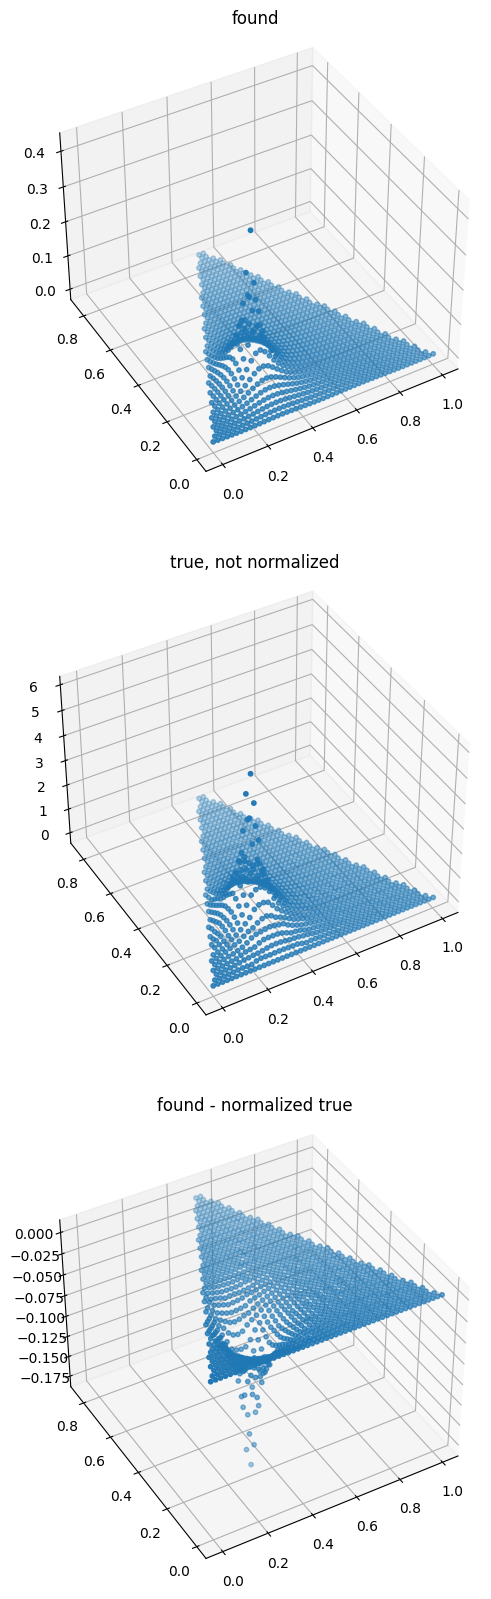

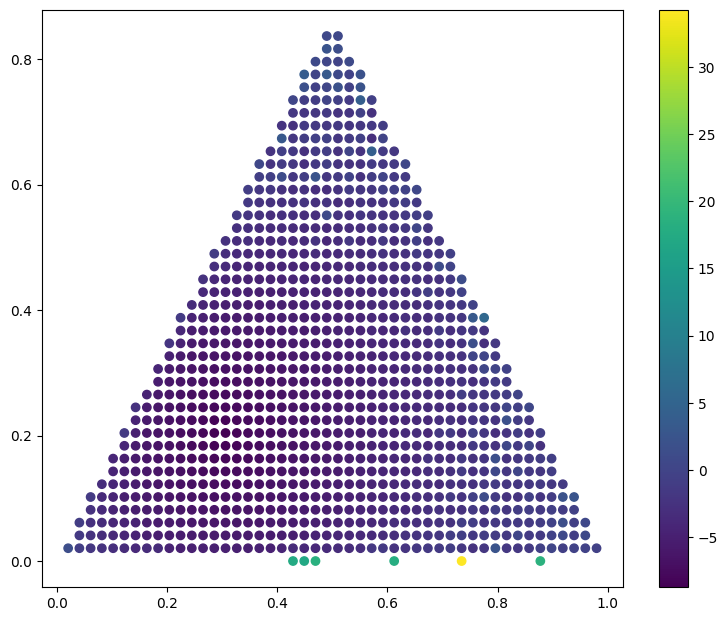

In [287]:
sizeparam = 20
fig = plt.figure(figsize=(sizeparam*3,sizeparam))


zz = pred.cpu().detach()
g0 = green_no_boundary(xy_grid[:,0].cpu().detach(), xy_grid[:,1].cpu().detach(), x_2, y_2).view(-1,1)

ax = fig.add_subplot(311, projection='3d')
ax.view_init(elev=40., azim=-120)
ax.set_title("found")
ax.scatter(xy_grid[:,0].cpu().detach(), xy_grid[:,1].cpu().detach(), g0 - zz, s=10)

ax = fig.add_subplot(312, projection='3d')
ax.view_init(elev=40., azim=-120)
ax.set_title("true, not normalized")
ax.scatter(xy_grid[:,0].cpu().detach(), xy_grid[:,1].cpu().detach(), true_triangle, s=10)



ax = fig.add_subplot(313, projection='3d')
ax.view_init(elev=40., azim=-120)
ax.set_title("found - normalized true")
ax.scatter(xy_grid[:,0].cpu().detach(), xy_grid[:,1].cpu().detach(), ((g0 - zz)[0] - true_triangle*0.03), s=10)

sizeparam = 3*Nx/20
plt.figure(figsize=(1.25*sizeparam,sizeparam))

plt.scatter(xy_grid[:,0].cpu().detach(), xy_grid[:,1].cpu().detach(), c = torch.log(torch.abs((g0 - zz)[0] / true_triangle*coeff)))
plt.colorbar()
plt.show()